In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import decision_infovalue
import importlib
importlib.reload(decision_infovalue)

<module 'decision_infovalue' from '/Users/guoziyang/Documents/Documents - GuoZiYang的MacBook Pro/info-value-toolkit/decision_infovalue/__init__.py'>

# Data preparation

In [44]:
data, metadata = decision_infovalue.get_dataset("haiid")
data = data[data['task_name'] != "dermatology"]
data.head()

/Users/guoziyang/Documents/Documents - GuoZiYang的MacBook Pro/info-value-toolkit/decision_infovalue/datasets.py:159: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(cache(github_data_url+ "haiid_dataset.csv"))


,task_name,ai_pred,h_pred,h_ai_pred,gt
0,art,0.400625,0.81,0.56,0
1,art,0.928542,1.00,0.99,1
2,art,0.623333,0.03,0.33,1
3,art,0.481667,0.94,0.53,0
4,art,0.202917,0.42,0.33,0


# Information Model

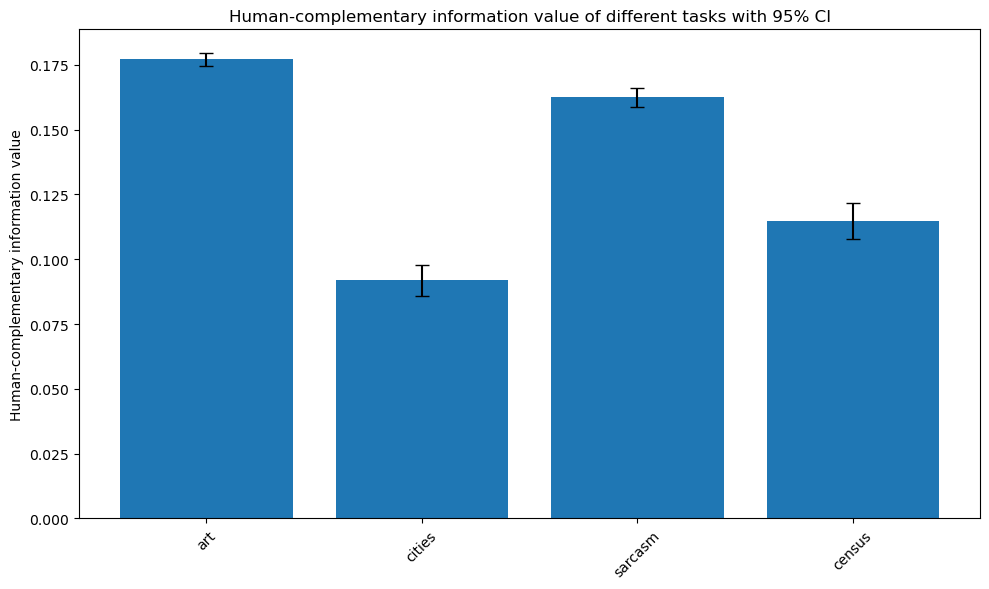

In [ ]:
from scipy import stats

task_list = list(data['task_name'].unique())
values = []
stds = []

for task in task_list:
    info_model = decision_infovalue.DecisionInfoModel(data.loc[data['task_name'] == task, :], metadata["target_name"], 
                                     signals=["ai_pred", "h_pred"], 
                                     scoring_rule="brier",
                                     fit_test_ratio=0.8,
                                     overfit_tolerance=0.1)
    # print("Break points for [{}]: ".format(task), info_model.all_breaks)
    value, std = info_model.complement_info_value("ai_pred", "h_pred", True)
    values.append(value)
    stds.append(std)

confidence_intervals = [stats.t.interval(0.95, len(data)-1, loc=value, scale=std) for value, std in zip(values, stds)]
ci_errors = np.array([(m - ci[0], ci[1] - m) for m, ci in zip(values, confidence_intervals)]).T

plt.figure(figsize=(10, 6))
plt.bar(task_list, values, yerr=ci_errors, capsize=5)
plt.xticks(rotation=45)
plt.ylabel('Human-complementary information value')
plt.title('Human-complementary information value of different tasks with 95% CI')
plt.tight_layout()
plt.savefig('./notebooks/observational-study/human_complementary_info_value.png', dpi=300, bbox_inches='tight')

In [57]:

# Calculate MSE for human and human+AI predictions
h_mse_list = []
hai_mse_list = []

for task in task_list:
    h_mse = ((data.loc[data['task_name'] == task, 'h_pred'] - data.loc[data['task_name'] == task, 'gt'])**2).mean()
    hai_mse = ((data.loc[data['task_name'] == task, 'h_ai_pred'] - data.loc[data['task_name'] == task, 'gt'])**2).mean()
    h_mse_list.append(h_mse)
    hai_mse_list.append(hai_mse)

# Create and display the table
from tabulate import tabulate

table_data = []
for i, task, value, h_mse, hai_mse in zip(range(len(task_list)), task_list, values, h_mse_list, hai_mse_list):
    table_data.append([task, f"{value:.4f} [CI95%: {value - ci_errors[0][i]:.4f}, {value + ci_errors[1][i]:.4f}]", f"{h_mse:.4f}", f"{hai_mse:.4f}", f"{h_mse - hai_mse:.4f}"])

headers = ["Task", "Human-complementary Info", "Human MSE", "Human+AI MSE", "Reduction in MSE"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------+--------------------------------+-------------+----------------+--------------------+
| Task    | Human-complementary Info       |   Human MSE |   Human+AI MSE |   Reduction in MSE |
+=========+================================+=============+================+====================+
| art     | 0.1772 [CI95%: 0.1747, 0.1798] |      0.243  |         0.1847 |             0.0583 |
+---------+--------------------------------+-------------+----------------+--------------------+
| cities  | 0.0919 [CI95%: 0.0860, 0.0978] |      0.1955 |         0.1615 |             0.034  |
+---------+--------------------------------+-------------+----------------+--------------------+
| sarcasm | 0.1625 [CI95%: 0.1587, 0.1662] |      0.2137 |         0.1767 |             0.037  |
+---------+--------------------------------+-------------+----------------+--------------------+
| census  | 0.1147 [CI95%: 0.1077, 0.1217] |      0.1997 |         0.1861 |             0.0136 |
+---------+-------------------